# Assignment 1

Matrikelnr.: 2089929

## Imports

In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

## Überblick und Vorbereitung der Daten

### Import

In [397]:
df_stroke_data = pd.read_csv('01_Classification_stroke_data.csv')

In [398]:
df_stroke_data.head(500)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
495,34299,Female,71.0,0,0,Yes,Private,Urban,93.28,34.7,never smoked,0
496,54375,Male,5.0,0,0,No,children,Rural,122.19,35.0,Unknown,0
497,37832,Female,14.0,0,0,No,children,Rural,129.53,21.3,never smoked,0
498,21058,Female,15.0,0,0,No,children,Rural,114.53,29.1,Unknown,0


Mit der `head()` Funktion sehen wir:
- Es handelt sich scheinbar um Patientendaten. 
- Die Felder bestehen aus verschiedenen Datentypen, u.a. Zahlenwerte (sowohl ganz als auch rational), Zeichenketten.  
- Die Felder `hypertension`, `heart_disease`, `ever_married` und `stroke` scheinen nur aus booleschen Werten zu bestehen (1 und 0 bzw. yes und no). 

In [399]:
df_stroke_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Die `describe()` Methode gibt weitere Einblicke in die Daten:
- Alle Spalten haben 5110 Einträge, außer BMI, die 4909 nicht-fehlende Werte hat.
- Das durchschnittliche Alter der Personen im Datensatz beträgt etwa 43,23 Jahre. Die Standardabweichung beträgt hier etwa 22,61. Die jüngste Person ist 0,08 Jahre alt, die älteste 82 Jahre. 25% der Personen im Datensatz sind 25 Jahre alt oder jünger. Der Median des Alters beträgt 45 Jahre. 75% der Personen im Datensatz sind 61 Jahre oder jünger.
- Etwa 5% der Personen im Datensatz haben eine Herzerkrankung. 
- Circa 9,7% der Patienten leiden unter Bluthochdruck.  
- Etwa 65% aller Patienten waren oder sind verheiratet.
- Etwa 4,8% der Patienten hatten einen Schlaganfall.

Jetzt verschaffen wir uns noch einen Überblick über die Spalten, in denen Zeichenketten stehen.

In [400]:
df_stroke_data['gender'].value_counts(normalize=True) * 100

gender
Female    58.590998
Male      41.389432
Other      0.019569
Name: proportion, dtype: float64

Etwa 58% der Patienten sind weiblich, etwa 41% männlich.

In [401]:
df_stroke_data['smoking_status'].value_counts(normalize=True) * 100

smoking_status
never smoked       37.025440
Unknown            30.215264
formerly smoked    17.318982
smokes             15.440313
Name: proportion, dtype: float64

Circa 37% der Patienten haben nie geraucht, 15% sind raucher und 17% haben mit dem Rauchen aufgehört. Bei 30% ist nicht bekannt, ob sie jemals geraucht haben oder rauchen. 

In [402]:
df_stroke_data['work_type'].value_counts(normalize=True) * 100

work_type
Private          57.240705
Self-employed    16.027397
children         13.444227
Govt_job         12.857143
Never_worked      0.430528
Name: proportion, dtype: float64

Der Großteil aller Personen im Datensatz ist "Privat" beschäftigt, also wahrscheinlich in einem Angestelltenverhältnis.

In [403]:
df_stroke_data['Residence_type'].value_counts(normalize=True) * 100

Residence_type
Urban    50.802348
Rural    49.197652
Name: proportion, dtype: float64

Das Verhältnis zwischen Land- und Stadtbewohnern ist recht gleichmäßig, es beträgt nahezu 50%.

### Nullwerte
Nun entfernen wir noch Nullwerte aus den Daten.

In [404]:
df_stroke_data = df_stroke_data.dropna()

### Encoding

In [405]:
df_stroke_data['ever_married'] = df_stroke_data['ever_married'].replace({'Yes': 1, 'No': 0})
df_stroke_data['gender'] = df_stroke_data['gender'].replace({'Male': 0, 'Female': 1, 'Other': 2})
df_stroke_data['Residence_type'] = df_stroke_data['Residence_type'].replace({'Rural': 0, 'Urban': 1})
df_stroke_data['smoking_status'] = df_stroke_data['smoking_status'].replace({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': 3})
df_stroke_data['work_type'] = df_stroke_data['work_type'].replace({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})

### Trainings- und Testdatensplit
Nun splitte ich den Datensatz in Trainings- und Testdaten. Der Anteil an Testdaten entspricht 30%.

In [406]:
# Aufteilen in Features und Labels
x = df_stroke_data[['gender', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']]  # Features
y = df_stroke_data.stroke # Label

# Split in Test- und Trainingsdaten
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Aufgabe 1
Apply three different simple machine learning models, which we discussed in lecture 02. Describe your approach, interpret the performance, and justify (based on the results) which machine learning model you would choose.

### Decision Tree
Als erstes Modell habe ich den Entscheidungsbaum gewählt.

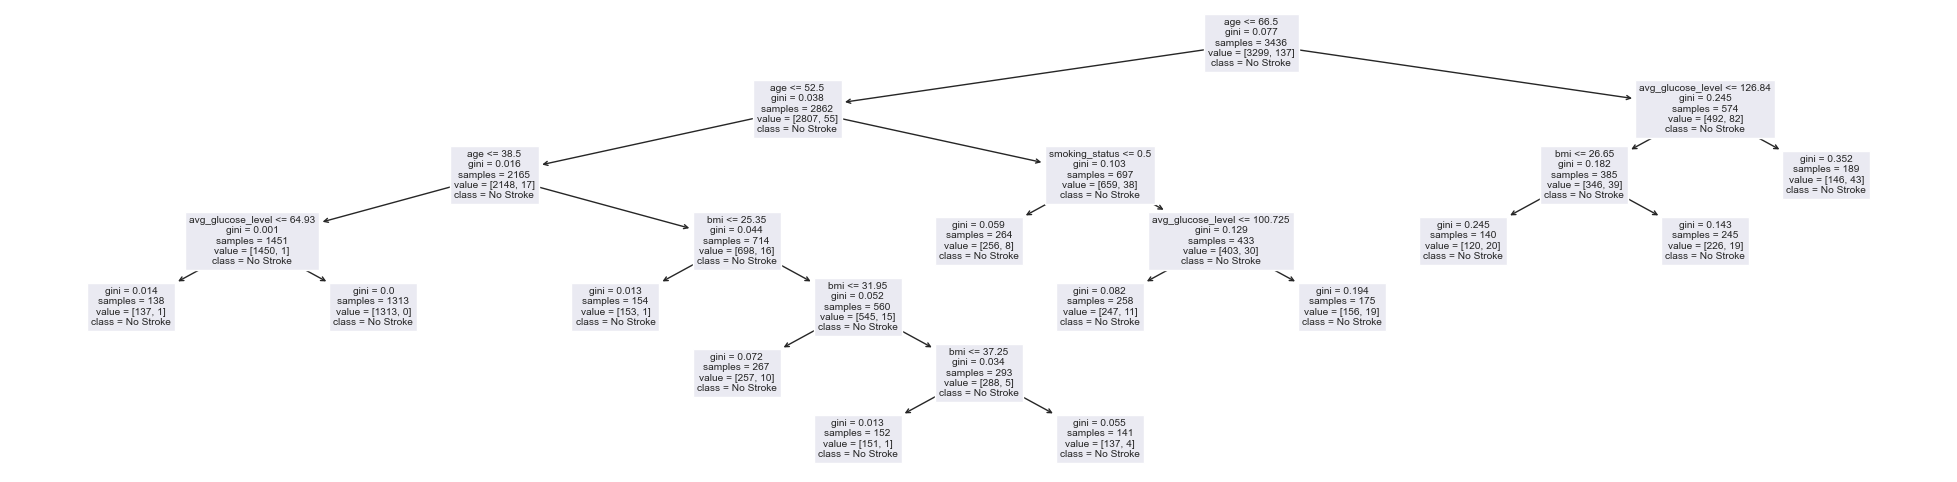

In [407]:
# Erstellen des Entscheidungsbaums mit den Trainingsdaten
tree = DecisionTreeClassifier(random_state=42, min_samples_leaf=0.04)
tree = tree.fit(x_train, y_train)

# Vorhersage auf den Testdaten und Bewertung der Genauigkeit
y_pred_dtree = tree.predict(x_test)

#Visualisierung des Entscheidungsbaums
fig, ax = plt.subplots(figsize=(25, 6))
plot_tree(tree, feature_names=x.columns.tolist(), ax=ax, class_names=['No Stroke', 'Stroke'])
plt.show()

In [408]:
print("Accuracy: ", accuracy_score(y_test, y_pred_dtree))
print("Precision: ", precision_score(y_test, y_pred_dtree))
print("Recall: ", recall_score(y_test, y_pred_dtree))
print("F1-Score: ", f1_score(y_test, y_pred_dtree))

Accuracy:  0.9511201629327902
Precision:  0.0
Recall:  0.0
F1-Score:  0.0


/Users/leonbittnerprivat/PycharmProjects/DataScienceWS2324/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Wir sehen, dass der Entscheidungsbaum eine hohe Genauigkeit (Accuracy) von etwa 95% erreicht hat. Dies könnte jedoch irreführend sein, da sowohl die Präzision (Precision) als auch der Recall und der F1-Score bei 0 liegen. Diese Werte deuten darauf hin, dass der Baum zwar gut darin ist, Nicht-Schlaganfall-Fälle („No Stroke“) zu identifizieren, aber keine einzige korrekte Vorhersage für Schlaganfall-Fälle („Stroke“) getroffen hat. Dies könnte auf ein unausgewogenes Datenset hinweisen, bei dem Schlaganfall-Fälle unterrepräsentiert sind. Die hohe Genauigkeit ist in diesem Fall irreführend und zeigt, dass das Modell nicht effektiv ist, um alle relevanten Klassen, insbesondere die kritische Klasse „Stroke“, zu erkennen.

### Naive Bayes Model
Als zweites Modell wende ich das Naive Bayes Model an.

In [409]:
# Gaussian Classifier
churn_gbn = GaussianNB()

# Training des Models auf dem Trainingsdatensatz
churn_gbn.fit(x_train, y_train)

# Prediction auf den Testdaten
y_pred_nb = churn_gbn.predict(x_test)

#### Evaluierung

In [410]:
print("Accuracy: ", accuracy_score(y_test, y_pred_nb))
print("Precision: ", precision_score(y_test, y_pred_nb))
print("Recall: ", recall_score(y_test, y_pred_nb))
print("F1-Score: ", f1_score(y_test, y_pred_nb))

Accuracy:  0.8811948404616429
Precision:  0.18787878787878787
Recall:  0.4305555555555556
F1-Score:  0.26160337552742613


Wir sehen, dass der Naive-Bayes-Classifier eine Genauigkeit (Accuracy) von etwa 88% erreicht hat, was auf den ersten Blick positiv erscheint. Allerdings zeigt die Präzision (Precision) von etwa 19%, dass von allen als positiv klassifizierten Fällen nur ein geringer Teil tatsächlich positiv ist. Der Recall von etwa 43% bedeutet, dass das Modell weniger als die Hälfte der tatsächlich positiven Fälle korrekt erkennt. Der F1-Score, der ein harmonisches Mittel aus Präzision und Recall darstellt, ist mit etwa 26% ebenfalls niedrig. Diese Werte deuten darauf hin, dass das Modell Schwierigkeiten hat, die positive Klasse effektiv zu identifizieren, was zu vielen falsch positiven und falsch negativen Ergebnissen führt.

### Logistische Regression
Als drittes Modell wende ich die logistische Regression an.

In [411]:
# Initialisierung des Modells
logreg = LogisticRegression(max_iter=500)

# Training des Modells auf den Trainingsdaten
logreg.fit(x_train, y_train)

# Prediction auf den Testdaten
y_pred_logreg = logreg.predict(x_test)

In [412]:
print("Accuracy: ", accuracy_score(y_test, y_pred_logreg))
print("Precision: ", precision_score(y_test, y_pred_logreg))
print("Recall: ", recall_score(y_test, y_pred_logreg))
print("F1-Score: ", f1_score(y_test, y_pred_logreg))

Accuracy:  0.9511201629327902
Precision:  0.0
Recall:  0.0
F1-Score:  0.0


/Users/leonbittnerprivat/PycharmProjects/DataScienceWS2324/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hier erreicht das Modell eine Genauigkeit von 95%. Jedoch zeigen Präzision, Recall und F1-Score jeweils einen Wert von 0, was auf eine mangelnde Fähigkeit des Modells hinweist, die positiven Fälle korrekt zu klassifizieren. Diese Diskrepanz zwischen hoher Genauigkeit und niedrigen Werten für die anderen Metriken deutet auf ein unausgewogenes Verhältnis der Klassen im Datensatz hin. Das Modell neigt dazu, alle Fälle als die dominierende Klasse vorherzusagen, was zu einer hohen Genauigkeit führt, aber es versagt dabei, die Minderheitenklasse effektiv zu identifizieren. 

### Konfusionsmatrix
Nun erstellen wir noch für jedes Modell eine Konfusionsmatrix. Die Konfusionsmatrizen vergleichen die vorhergesagten Kennzeichnungen mit den wahren Kennzeichnungen des Modells. 

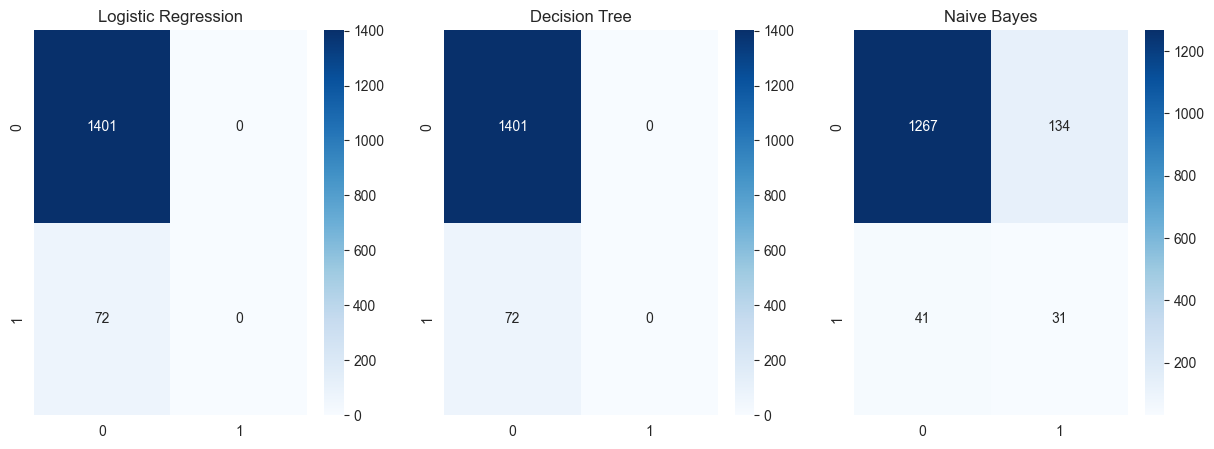

In [413]:
# Für den Entscheidungsbaum
cm_dtree = confusion_matrix(y_test, y_pred_dtree)

# Für Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Für die logistische Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Konfusionsmatrix anzeigen
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_logreg, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('Logistic Regression')

sns.heatmap(cm_dtree, annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title('Decision Tree')

sns.heatmap(cm_nb, annot=True, fmt='d', ax=ax[2], cmap='Blues')
ax[2].set_title('Naive Bayes')

plt.show()

Grundsätzlich lässt sich sagen, dass die Performance aller drei Modelle nicht sehr gut ist. Alle Modelle haben eine signifikante Zahl an False Positives und eine geringe Zahl an True Positives. Im Vergleich schneidet der Entscheidungsbaum minimal besser ab als die anderen beiden Modelle. Es wird deshalb mit diesem Modell fortgefahren.

## Aufgabe 2
Select the machine learning model that you have chosen in task 1. Now try
optimizing your results by applying the advanced concepts (lecture 04) and analyze
if the model is overfitted or underfitted (lecture 04). Use cross-validation (lecture
04) when evaluating your results. Describe your approach, interpret the
performance, and justify which machine learning model you would choose.

### Resampling
Aufgabe 1 hat bereits ein Ungleichgewicht der Trainingsdaten angedeutet, welches wird nun prüfen.

In [414]:
print(y_train.value_counts())

stroke
0    3299
1     137
Name: count, dtype: int64


Wir sehen ein Ungleichgewicht zwischen Patienten mit Schlaganfall und ohne. Um dies auszugleichen, wende ich die over-sampling Methode SMOTE (Synthetic Minority Over-sampling Technique) an, um die Azahl der Klassen, die sich in der Minderheit befinden, zu erhöhen. Hierfür nutze ich das Package `over_sampling` von imbalanced-learn.

In [415]:
smote = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = smote.fit_resample(x_train, y_train)
print(y_train_oversampled.value_counts())

stroke
0    3299
1    3299
Name: count, dtype: int64


In [416]:
x_train_oversampled

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status
0,1,14.000000,0,0,72.360000,20.500000,3
1,1,58.000000,0,0,65.660000,24.600000,1
2,1,60.000000,0,0,99.000000,26.100000,0
3,1,19.000000,0,0,79.250000,23.600000,3
4,1,82.000000,0,0,82.630000,17.900000,2
...,...,...,...,...,...,...,...
6593,0,80.821142,0,0,252.453215,28.743887,2
6594,1,74.969491,0,0,78.682845,29.217625,0
6595,1,80.638222,0,1,215.100237,28.036178,0
6596,0,74.958002,0,0,132.287541,26.033598,0


## Feature Extraction
Im nachfolgenden werden zuerst die Spalten identifiziert, bei denen eine Feature Extraction sich lohnen könnte.

In [417]:
df_stroke_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,0,1,228.69,36.6,1,1
2,31112,0,80.0,0,1,1,0,0,105.92,32.5,0,1
3,60182,1,49.0,0,0,1,0,1,171.23,34.4,2,1
4,1665,1,79.0,1,0,1,1,0,174.12,24.0,0,1
5,56669,0,81.0,0,0,1,0,1,186.21,29.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,1,13.0,0,0,0,3,0,103.08,18.6,3,0
5106,44873,1,81.0,0,0,1,1,1,125.20,40.0,0,0
5107,19723,1,35.0,0,0,1,1,0,82.99,30.6,0,0
5108,37544,0,51.0,0,0,1,0,0,166.29,25.6,1,0


Text(0.5, 1.0, 'BMI')

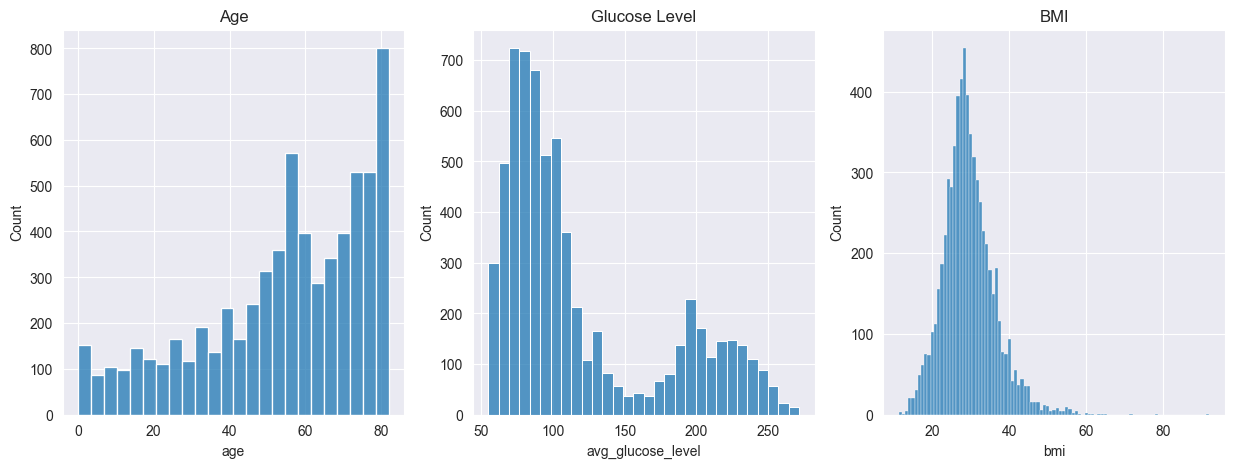

In [418]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(x_train_oversampled['age'],ax=ax[0])
ax[0].set_title('Age')
sns.histplot(x_train_oversampled['avg_glucose_level'],ax=ax[1])
ax[1].set_title('Glucose Level')
sns.histplot(x_train_oversampled['bmi'],ax=ax[2])
ax[2].set_title('BMI')

Der Plot der Spalten Age, Glucose Level und BMI zeigt, dass hier viele fein stufige Merkmale vorhanden sind. Um eine Dimensionreduzierung zu erreichen, werden die folgenden Features zusammengefasst:

**Age**
- 0 bis 15 Jahre
- 16 bis 30 Jahre
- 31 bis 45 Jahre
- 46 bis 60 Jahre
- 61 bis 75 Jahre
- 76 bis 99 Jahre

**Glucose Level**
Es werden 20er Schritte von 50 bis 300 gebildet.

**BMI**
Es werden 10er Schritte von 10 bis 100 gebildet.

In [419]:
x_train_extracted = x_train_oversampled

# Feature Extraction for Age
bins = [0, 15, 30, 45, 60, 75, np.inf]
names = ['<16', '16-30', '31-45','46-60','61-75','76+']
x_train_extracted['age'] = pd.cut(x_train_extracted['age'], bins, labels=names)

# Feature Extraction for Glucose Level
bins = np.arange(50, 300, 20)
bins = np.append(bins, np.inf)
labels = ['50-70', '70-90', '90-110', '110-130', '130-150', '150-170', '170-190',
          '190-210', '210-230', '230-250', '250-270', '270-290', '290+']
x_train_extracted['avg_glucose_level'] = pd.cut(x_train_extracted['avg_glucose_level'], bins=bins, labels=labels, include_lowest=True)

# Feature Extraction for BMI
bins = np.arange(10, 110, 10)
bins = np.append(bins, np.inf)
labels = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+']
x_train_extracted['bmi'] = pd.cut(x_train_extracted['bmi'], bins=bins, labels=labels, include_lowest=True)

Text(0.5, 1.0, 'BMI')

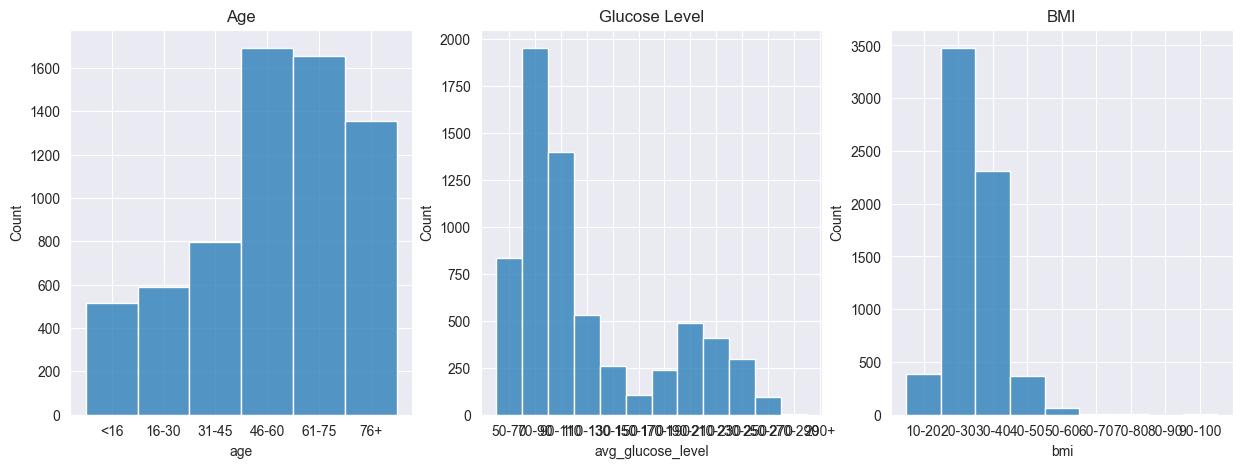

In [420]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(x_train_extracted['age'],ax=ax[0])
ax[0].set_title('Age')
sns.histplot(x_train_extracted['avg_glucose_level'],ax=ax[1])
ax[1].set_title('Glucose Level')
sns.histplot(x_train_extracted['bmi'],ax=ax[2])
ax[2].set_title('BMI')

Die zusammengefassten Features werden jetzt noch encoded:

In [421]:
x_train_extracted['age'] = x_train_extracted['age'].replace({'<16': 0, '16-30': 1, '31-45': 2, '46-60': 3, '61-75': 4, '76+': 5})

x_train_extracted['avg_glucose_level'] = x_train_extracted['avg_glucose_level'].replace({
    '50-70': 0,
    '70-90': 1,
    '90-110': 2,
    '110-130': 3,
    '130-150': 4,
    '150-170': 5,
    '170-190': 6,
    '190-210': 7,
    '210-230': 8,
    '230-250': 9,
    '250-270': 10,
    '270-290': 11,
    '290+': 12})

x_train_extracted['bmi'] = x_train_extracted['bmi'].replace({
    '10-20': 0,
    '20-30': 1,
    '30-40': 2,
    '40-50': 3,
    '50-60': 4,
    '60-70': 5,
    '70-80': 6,
    '80-90': 7,
    '90-100': 8,
    '100+': 9})

## Neutrainieren des Modells

Zuerst wird ein neuer Trainingsdatensatz erstellt.

In [422]:
x_train_2, x_test, y_train_2, y_test = train_test_split(x_train_extracted, y_train_oversampled, test_size=0.3, random_state=42)

Anschließend wird das Naive-Bayes Modells erneut trainiert.

In [423]:
# Training des Models auf dem Trainingsdatensatz
churn_gbn.fit(x_train_2, y_train_2)

# Prediction auf den Testdaten
y_pred_nb = churn_gbn.predict(x_test)

Nun bewerten wir Accuracy, Precision, Recall und F1-Score neu:

In [424]:
print("Accuracy: ", accuracy_score(y_test, y_pred_nb))
print("Precision: ", precision_score(y_test, y_pred_nb))
print("Recall: ", recall_score(y_test, y_pred_nb))
print("F1-Score: ", f1_score(y_test, y_pred_nb))

Accuracy:  0.7575757575757576
Precision:  0.7253588516746412
Recall:  0.7970557308096741
F1-Score:  0.7595190380761523


Nach den Anpassungen des Naive-Bayes-Modells zeigen die Metriken eine bessere Leistung. Mit einer Genauigkeit von etwa 76% erbringt das Modell insgesamt eine akzeptable Vorhersageleistung. Die Präzision von rund 73% und ein Recall von etwa 80% weisen darauf hin, dass das Modell eine relativ hohe Rate an korrekten positiven Vorhersagen macht und dabei auch einen Großteil der tatsächlich positiven Fälle erfasst. Der F1-Score von etwa 76% unterstreicht diese ausgewogene Leistung zwischen Präzision und Recall.

Obwohl die verbesserten Werte des Modells vielversprechend sind, sollte beachtet werden, dass eine Genauigkeit von 76% bedeutet, dass etwa ein Viertel der Vorhersagen falsch sein könnten. Dies kann in klinischen Anwendungen, wo Fehldiagnosen schwerwiegende Folgen haben können, kritisch sein.

Zur weiteren Analyse wird eine neue Konfusionsmatrix erstellt.

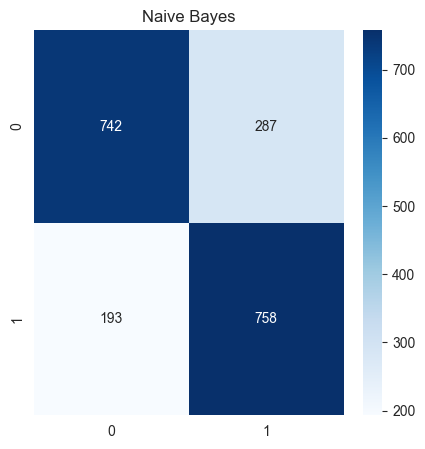

In [425]:
# For Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Konfusionsmatrix anzeigen
plt.figure(figsize=(5, 5))

sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes')

plt.show()

Nach der Optimierung und dem Oversampling stieg die Anzahl der TP auf 758, was eine deutlich verbesserte Fähigkeit des Modells zeigt, die Stroke-Klasse zu identifizieren. Dies ist ein erwartetes Ergebnis des Oversampling, da es dem Modell mehr Beispiele der Minderheitsklasse zur Verfügung stellt, wodurch es besser lernt, diese zu erkennen. Die TN reduzierten sich auf 742, was darauf hindeutet, dass durch das Oversampling möglicherweise eine leichte Verzerrung zugunsten der Minderheitsklasse entstanden ist, die zu einer höheren Anzahl von FP (287) führte. Dieser Anstieg der FP kann die Präzision negativ beeinflussen, aber die verbesserte Erkennung der Stroke-Fälle (höherer Recall) kann in praktischen Anwendungen, insbesondere im Gesundheitswesen, als vorteilhaft angesehen werden, da es oft wichtiger ist, alle potenziellen Stroke-Fälle zu erkennen, auch wenn dabei einige falsch positive Diagnosen in Kauf genommen werden müssen.

Insgesamt zeigt die optimierte Konfusionsmatrix, dass das Modell nach dem Oversampling eine höhere Sensitivität aufweist. Dies kann in Anwendungen, wo das frühzeitige Erkennen einer Erkrankung kritisch ist, von großem Nutzen sein, selbst wenn dies eine höhere Rate an falsch positiven Ergebnissen bedeutet. Für einen produktiven Einsatz ist die Performance des Modells allerdings noch nicht ausreichend.

## Cross Validation
Um eine robustere Bewertung des optimierten Modells zu gewährleisten, wende ich Cross-Validation (CV) an. CV ist nützlich, um zu verhindern, dass das Modell eine hohe Performance nur auf einem speziellen Testdatensatz erzielt, während es in anderen Fällen schlecht abschneidet. Dies könnte passieren, wenn der Testdatensatz zufällig Merkmale enthält, die dem Modell bereits aus den Trainingsdaten bekannt sind (Overfitting). Durch CV kann die Bewertung des Modells allgemeiner und zuverlässiger gemacht werden.


In [426]:
# 10-Fold Cross-Validation
scores = cross_val_score(churn_gbn, x_train_2, y_train_2, cv=10)

# Anzeigen der Genauigkeit
print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-Validation Accuracy: 0.77 (+/- 0.04)


Die Cross-Validation-Genauigkeit von 0.77 (+/- 0.04) zeigt, dass das Modell eine zufriedenstellende und konsistente Vorhersageleistung hat. Die geringe Standardabweichung deutet darauf hin, dass das Modell weder over- noch underfitted, da es über verschiedene Datensätze hinweg ähnliche Ergebnisse liefert.